#Wine Quality Prediction through SVM and LR
- Data Exploration and Preprocessing

    - Explore the dataset thoroughly and provide a summary of your observations.
    - Perform necessary preprocessing steps:
        * Preparing feature values to be used by your models.
        * Optionally, data augmentation techniques.
        * Splitting the data into training and test sets appropriately.

- SVM and LR Implementation
    - Implement both SVM and LR from scratch. Evaluate and compare their performance.
    - Clearly define the two models and describe your implementation, also listing their hyperparameters if any.
    - Train the two models using an appropriate performance metric.
    - Demonstrate proper hyperparameter tuning, and evaluate at least one of your models using accuracy estimates via 5-fold cross-validation.

- Kernel Methods
    - Extend the above models to a kernelized form by adopting non-linear kernels.
    - Clearly describe how the kernelization happens and its consequences for both predictions and performance.
    - Comment on how the kernelized models compare with respect to the standard ones.

- Evaluation and Analysis
    - Evaluate your model performance using suitable metrics such as accuracy, precision, recall, and F1-score.
    - Provide appropriate visualizations of the performance of each model (loss and accuracy).
    - When reasonable, conduct an analysis of misclassified examples to understand potential model limitations.
    - Discuss the presence or absence of overfitting and underfitting at any point.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
#to output plots within the notebook
%matplotlib inline

import importlib
import inspect
import os
import sys

%cd /content/
!ls -R
repo_name = "WineQualityPrediction"
#!rm -rf {repo_name}
if not os.path.exists(repo_name):
    print(f"Directory {repo_name} does not exist, proceeding with clone.")
    !git clone https://github.com/Abudo-S/WineQualityPrediction.git

%cd WineQualityPrediction


import PCA as PCA_Module
import SVM as SVM_Module
import LogisticRegression as LogisticRegression_Module
import KCrossValidation as KCrossValidation_Module
import Kernel as Kernel_Module
importlib.reload(PCA_Module) # in case of updates
importlib.reload(SVM_Module) # in case of updates
importlib.reload(LogisticRegression_Module) # in case of updates
importlib.reload(KCrossValidation_Module) # in case of updates
importlib.reload(Kernel_Module) # in case of updates
from PCA import PCA
from SVM import SVM
from LogisticRegression import LogisticRegression
from KCrossValidation import KCrossValidation
from Kernel import Kernel

/content
.:
sample_data  WineQualityPrediction

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

./WineQualityPrediction:
KCrossValidation.py    PCA.py	    wine+quality
Kernel.py	       __pycache__  WineQualityPrediction.ipynb
LogisticRegression.py  SVM.py

./WineQualityPrediction/__pycache__:
KCrossValidation.cpython-311.pyc    PCA.cpython-311.pyc
Kernel.cpython-311.pyc		    SVM.cpython-311.pyc
LogisticRegression.cpython-311.pyc

./WineQualityPrediction/wine+quality:
winequality.names  winequality-red.csv	winequality-white.csv
/content/WineQualityPrediction


# General observations:
- The red-wine dataset as well as the white-wine dataset have the same features labeled with the same target feature "quality".
- All feature values are numeric with no NaN values.
- Both datasets contain some duplicated instances.
- We'd need to combine both datasets in order to develop a universal model for both of red and white wines, by introducing a new feature 'wine_type' valorized with 1: for red wine instance, 0: for white wine instance.
In fact, introducing a new feature for the wine type the learning model would be to build relationships between the wine type and the other features.
By combining both datasets, we're increasing the training-set volume which gives the possibility to the learning model to see further records, so it reduces the risk of overfitting.

In [70]:
red_wine_quality = pd.read_csv("/content/WineQualityPrediction/wine+quality/winequality-red.csv", sep=';')
red_wine_quality.info()

white_wine_quality = pd.read_csv("/content/WineQualityPrediction/wine+quality/winequality-white.csv", sep=';')
white_wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column        

Introduce categorical feature "wine_type" in red_wine_quality and white_wine_quality datasets

In [71]:
red_wine_quality['wine_type'] = 1 #red wine
white_wine_quality['wine_type'] = -1 #white wine

Combine red_wine_quality and white_wine_quality datasets

In [72]:
wine_quality = pd.concat([red_wine_quality, white_wine_quality], ignore_index=True);
wine_quality.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


# Observations on data duplication
Duplicated instances might lead to data leakage in which after dataset splitting into training and test sets, there might be identical records in both splitted sets. The model also becomes too specialized to the training data, including the duplicated instances, which will cause the problem of overfitting.
Furthermore, there'd be additional elaboration cost of redundant data.

Remove duplicates

In [73]:
#wine_quality.info() # initial enteries 6497
wine_quality = wine_quality.drop_duplicates(keep='first')
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5320 non-null   float64
 1   volatile acidity      5320 non-null   float64
 2   citric acid           5320 non-null   float64
 3   residual sugar        5320 non-null   float64
 4   chlorides             5320 non-null   float64
 5   free sulfur dioxide   5320 non-null   float64
 6   total sulfur dioxide  5320 non-null   float64
 7   density               5320 non-null   float64
 8   pH                    5320 non-null   float64
 9   sulphates             5320 non-null   float64
 10  alcohol               5320 non-null   float64
 11  quality               5320 non-null   int64  
 12  wine_type             5320 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 581.9 KB


#Observation on dataset dimenstionality
Since we have 5320 examples for 12 features (excluding the target label "quality"), which gives us the following ratio of samples to features (~443:1).  
The ratio we have is considered a high ratio which gives us several examples per features avoiding the curse of dimensionality. The curse of dimensionality commonly verifies when we don't have enough examples that describe the dataset w.r.t. the number of dimensions.
Having a high ratio of samples to features implies that we might not need to apply dimensionality reduction technique (ex. PCA).

# Observations on data distribution within quality's values
As we can notice, the range of values for our target column "quality" is [3:9] inclusive.
But we have a clear imbalance within quality's values "less data examples for extremely low or extremely high values" (like quality 3, 4, 8, or 9), meanwhile for middle values, we apparently have the majority of examples.

When we convert the continuous 'quality' score into a binary classification problem "good" (quality ≥ 6) or "bad" (quality < 6), we're essentially creating two classes for the label quality:

  * "Bad [-1]" class: Quality scores of 3, 4, 5. (represent 37% of the whole dataset).
  * "Good [1]" class: Quality scores of 6, 7, 8, 9 (represent 63% of the whole dataset).

We can clearly notice the imbalance with the data distribution over our two classes. Imbalanced data tends to be biased towards the majority class because it sees more examples of it. The model will struggle to correctly identify instances of the minority class.

### In case of SVM:
  In an imbalanced dataset, the majority class has many more data points. Consequently, the support vectors that define the decision boundary are dominated by instances from the majority class. Since the SVM algorithm's primary objective is to maximize the margin. The decision boundary (hyperplane) gets pushed towards the minority class; therefore, many instances of the minority class could be incorrectly classified as the majority class.

### In case of Logistic Regression:
The input space corresponding to these extremely low or extremely high quality scores will have very few data points, creating sparse regions. The model will learn to predict higher probabilities for the more frequent classes, assigning heigher weights to them. The decision boundary will be positioned to minimize overall prediction errors. Since errors on the majority class contribute more to the total loss, the model will prioritize correctly classifying the majority class instances, potentially pushing the boundary away from the minority class.

## Possible solutions:
* Data augumentation: Oversampling of the minority class through creating new relevant synthetic (not duplicated) samples, in order to enhance the presence of the minor class in the whole dataset.
* Weights Regularization: Regularizing the weights assigned to the minority class's instance, in order to mitigate the problem of imbalanced dataset and to give more importance to the less frequent class.

In [74]:
X = wine_quality.drop(columns='quality').values
#y = wine_quality['quality'].values #(array([3, 4, 5, 6, 7, 8, 9]), array([  30,  206, 1752, 2323,  856,  148,    5]))

#Map to binary values for column "quality" as "good=1" (quality ≥ 6) or "bad=-1" (quality < 6)
y = np.where(wine_quality['quality'] >= 6, 1, -1) #1988, 3332

print(f'Wine unique values: {np.unique(y, return_counts=True)}')

Wine unique values: (array([-1,  1]), array([1988, 3332]))


#Observations on feature scaling
Some features (ex. residual sugar, free sulfur dioxide, total sulfur dioxide, ...) which have high difference between the minumum and maximum values, will need to be standardized on the same scale.
Especially in case of models that aim to find an optimal hyperplane (ex. SVM) that maximizes the margin between different classes. The calculation of this margin and the positioning of the hyperplane rely on the distances between data points in the feature space.

In [75]:
minMax_feature_values = zip(wine_quality.columns, wine_quality.min(), wine_quality.max())
print(f'Minimum/Maximum values for each feature: {list(minMax_feature_values)}')


Minimum/Maximum values for each feature: [('fixed acidity', 3.8, 15.9), ('volatile acidity', 0.08, 1.58), ('citric acid', 0.0, 1.66), ('residual sugar', 0.6, 65.8), ('chlorides', 0.009, 0.611), ('free sulfur dioxide', 1.0, 289.0), ('total sulfur dioxide', 6.0, 440.0), ('density', 0.98711, 1.03898), ('pH', 2.72, 4.01), ('sulphates', 0.22, 2.0), ('alcohol', 8.0, 14.9), ('quality', 3.0, 9.0), ('wine_type', -1.0, 1.0)]


In [76]:
#Set a value in random_state to ensure reproducibility of data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'shape {X_train.shape}\n', X_train)

shape (4256, 12)
 [[ 6.8   0.26  0.33 ...  0.44 10.5  -1.  ]
 [ 6.8   0.25  0.38 ...  0.59 10.2  -1.  ]
 [10.2   0.42  0.57 ...  0.63  9.6   1.  ]
 ...
 [ 6.4   0.26  0.42 ...  0.47  9.1  -1.  ]
 [10.5   0.39  0.46 ...  0.84 11.4   1.  ]
 [ 7.3   0.28  0.42 ...  0.43 10.7  -1.  ]]


#Apply StandardScaler
standard_scaler.fit_transform() is used to compute mean the mean (μ) and standard deviation (σ) for each feature on the training data and then to rescale the training data.
The testing data are directly rescaled through standard_scaler.transform() using the parameters computed on the training data.
Generally, We should avoid scaling categorical features, they have discrete values and by scaling makes them, their values become continuous, which can mislead the learning models by lossing the interpretability and the nature of the target feature.
#### Note that dimension scaling is always applied after dataset splitting, in order to avoid data leakage from training set to test set.

In [77]:
standard_scaler = preprocessing.StandardScaler()
#exclude 'wine_type' index from scaling
partial_X_train_standard = standard_scaler.fit_transform(X_train[:, :11])
partial_X_test_standard = standard_scaler.transform(X_test[:, :11])

#concatenate 'wine_type' index after scaling
X_train_standard = np.hstack((partial_X_train_standard, X_train[:, 11:]))
X_test_standard = np.hstack((partial_X_test_standard, X_test[:, 11:]))

#Manual standardization using numpy
# mean_val = np.mean(X_train, axis=0)
# std_val = np.std(X_train, axis=0)
# std_val[std_val == 0] = 1.0

# X_train_standard = (X_test - mean_val) / std_val
# X_test_standard = (X_test - mean_val) / std_val

#print(f'scaled X_train_standard instances:{X_train_standard}\n scaled X_test_standard intances:{X_test_standard}')
minMax_feature_values = zip(wine_quality.drop(columns='quality').columns, X_train_standard.min(axis=1), X_train_standard.max(axis=1))
print(f'Minimum/Maximum values for each feature: {list(minMax_feature_values)}')
print(f'shape {X_train_standard.shape}\n', X_train_standard)

Minimum/Maximum values for each feature: [('fixed acidity', np.float64(-1.0), np.float64(0.9381780229918787)), ('volatile acidity', np.float64(-1.0), np.float64(0.7268019259463089)), ('citric acid', np.float64(-1.8273259133543258), np.float64(2.266593384211851)), ('residual sugar', np.float64(-1.510261767785971), np.float64(1.962701769967871)), ('chlorides', np.float64(-1.3263225891919668), np.float64(1.137584149236235)), ('free sulfur dioxide', np.float64(-1.3990770272548017), np.float64(8.264440659773356)), ('total sulfur dioxide', np.float64(-1.5597163204441749), np.float64(1.1926703891789439)), ('density', np.float64(-1.0919976609714168), np.float64(1.1422348194826384)), ('pH', np.float64(-1.4929146110942604), np.float64(0.25537067629674454)), ('sulphates', np.float64(-0.7961985529363579), np.float64(2.4814574943919676)), ('alcohol', np.float64(-1.0), np.float64(0.9615076819384121)), ('wine_type', np.float64(-1.3643305375469041), np.float64(0.2976580328266115))]
shape (4256, 12)
 [

#Should we apply PCA?

To extract only important features and reduce the dimensionality, therefore reducing the traing cost.
It could be needed, if we notice overfitting caused by irrelevant features.
Generally, in our case since we've already aforementioned that in our case the samples-to-features ratio is high, we don't need to reduce the number of dimensions. But just for an experiment we can try it. [it might be useful in case of further noticed overfitting!]

In [78]:
#importlib.reload(PCA_Module) # in case of manual updates on colab

pca = PCA(0.85) #85% gives us 6 features, meanwhile 90% of variance gives use 8 features
pca.fit(X_train_standard)

transformed_X_train_standard = pca.transform(X_train_standard)
transformed_X_test_standard = pca.transform(X_test_standard)

print(f'transformed X_train shape {transformed_X_train_standard.shape}\n', transformed_X_train_standard)
print(f'transformed X_test shape {transformed_X_test_standard.shape}\n', transformed_X_test_standard)

explained variance per comp. idxs[0 1 2 3 8 9]: [3.63133529 2.48334646 1.59109269 0.93734208 0.7444982  0.62646689]
explained variance ratio per comp. idxs[0 1 2 3 8 9]: [0.30846928 0.21095163 0.13515778 0.07962394 0.06324253 0.05321618]
transformed X_train shape (4256, 6)
 [[-1.47951127 -0.38046635 -0.30523229  0.13607761  0.96859456 -0.04236056]
 [-0.70705619  0.49253987  0.30440302  0.53786682 -0.78855677  0.58848193]
 [ 2.82520092  1.50857749 -2.55294943 -0.98976595 -0.31057844  0.71635078]
 ...
 [-1.2614114   1.24147684  0.30436017 -0.33248839 -0.14149082  0.85589743]
 [ 3.0390907   0.73452947 -2.73729087  0.2760119  -0.67316978 -0.76090439]
 [-1.03097199 -0.79798878 -0.9180024  -0.17954283  0.36714052  0.44658363]]
transformed X_test shape (1064, 6)
 [[-2.16779539  1.39917207  0.45937885  0.53831434  0.22963764  0.59687998]
 [-0.97651081 -0.20060253  0.78499306  0.05416821  0.08463279  1.6642136 ]
 [ 1.87976452  0.04080366  0.52339641 -0.96796637  0.12396409  0.0990446 ]
 ...
 [-

#SVM
Support vector machine aims to find an optimal hyperplane that best separates different classes in a dataset. The optimal hyperplane is the one that has the maximizied margin to the nearest training data points (support vectors) of any class.
For linearly separable data, there might be many possible hyperplanes that can separate the classes. And it'll be quite feasibile to find the optimal hyperplane.
For non-linearly separable date, we can introduce a generic approach which works also in case of linearity by exploiting the unconstrainted weights/bias update which uses:
<!-- * Margin score yi​(wTxi​+b): (score ​<1 : in case of correctly classified data point), (score​ ≥1 : in case of misclassified data point). -->
* Regularization parameter λ: A higher value of λ increases the cost of misclassifications, forcing the algorithm to try harder to classify all training points correctly,
even if it means a smaller margin. This can lead to a smaller margin and potentially overfitting if λ is too large.  
A lower value of λ decreases the cost of misclassifications, allowing the algorithm to have a larger margin,
even if it misclassifies some training points. This can lead to underfitting if λ is too small.

* The learning rate σ aims to adjust the weights and bias (determines how big of a step the algorithm takes in the direction opposite to the gradient) trying to reach the approximated convergence to the the optimal decision boundary.

The gradient descent strategy can be stocastic or batch: In our case we use the batch strategy in order to avoid the noisy updates in case of SGD.

Acc.:0.7180451127819549


<Figure size 640x480 with 0 Axes>

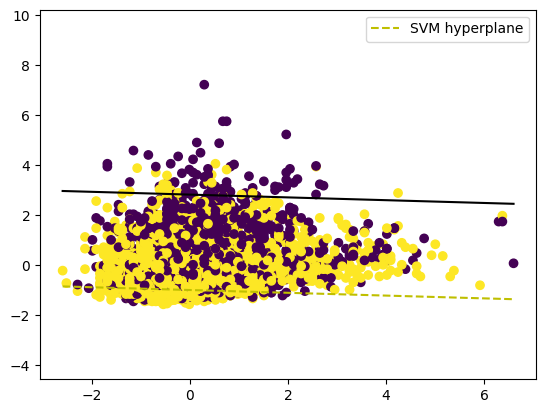

              precision    recall  f1-score   support

     bad[-1]       0.66      0.52      0.58       398
     good[1]       0.74      0.84      0.79       666

    accuracy                           0.72      1064
   macro avg       0.70      0.68      0.68      1064
weighted avg       0.71      0.72      0.71      1064



In [79]:
#importlib.reload(SVM_Module) # in case of manual updates on colab

#svm = SVM("SGD")
svm = SVM(n_iterations=1500)
# svm.fit(transformed_X_train_standard, y_train)
# predictions = svm.predict(transformed_X_test_standard)
svm.fit(X_train_standard, y_train, X_validation=X_test_standard, y_validation=y_test)
predictions = svm.predict(X_test_standard)
#svm.fit(X_train, y_train)
#predictions = svm.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Acc.:{accuracy}')

#print(inspect.signature(svm.visualize_svm))

svm.visualize_svm(np.vstack((X_train_standard, X_test_standard)), np.concatenate((y_train, y_test)))
# print(svm.weights)
# print(svm.bias)
print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

#Logistic Regression
It seeks to find a logaritmic equation(sigmoid) that best describes how one or more independent variables (features)
relate to a dependent variable (target label).
The model aims to find the "best-fit" approximated hyperplane that minimizes the gradient(not exact value predictor "based on a predefined threshold").
It squashes any real-valued number into a value between 0 and 1, which can be interpreted as a probability: σ(z)= 1 / (1+e^−z)

The learning rate σ aims to adjust the weights and bias (determines how big of a step the algorithm takes in the direction opposite to the gradient) trying to reach the approximated convergence to the optimal decision boundary.

Acc.:0.6597744360902256


<Figure size 640x480 with 0 Axes>

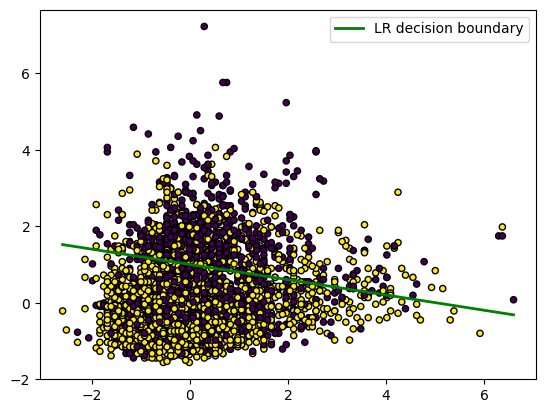

              precision    recall  f1-score   support

     bad[-1]       0.53      0.84      0.65       398
     good[1]       0.86      0.55      0.67       666

    accuracy                           0.66      1064
   macro avg       0.69      0.70      0.66      1064
weighted avg       0.73      0.66      0.66      1064



In [80]:
#importlib.reload(LogisticRegression_Module) # in case of manual updates on colab

lr = LogisticRegression()
# lr.fit(transformed_X_train_standard, y_train)
# predictions = lr.predict(transformed_X_test_standard)
lr.fit(X_train_standard, y_train, X_validation=X_test_standard, y_validation=y_test)
predictions = lr.predict(X_test_standard)
#lr.fit(X_train, y_train)
#predictions = lr.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Acc.:{accuracy}')

#print(inspect.signature(lr.visualize_svm))

lr.visualize_lr(np.vstack((X_train_standard, X_test_standard)), np.concatenate((y_train, y_test)))
#print(lr.weights)
#print(lr.bias)
print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

#Hyperparameter tuning
We'll try to apply k-fold cross validation on the logistic regression since it has a lower accuracy compared to SVM w.r.t. default hyperparameters per each predictor.
Let's break down the hyperparameters of logistic regression:
* Learning rate σ: the most common values of σ are [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]. If we choose define too high σ, we'll see a huge loss because of extremely large steps taken in weight updates. On the other hand, if we choose define too low σ, we'll have tiny steps taken in weight updates, leading to extremely slow convergence.  
Therefore, in our hyperparameter-tuning experience, we might need to tune only [0.001, 0.01, 0.1] since the other values are used for wider search.

* Number of iterations (epochs): the most common values of n.epochs are [50, 100, 200, 500, 1000, 2000].  
It's known that the number of epochs is the iterations taken to update weights till reaching an approximated optimal boundary decision.
High number of epochs might need lower number of learning rate that need to be proportionally adequate to the the step size * number of steps to take, in order to update the weights.  
So in our hyper-parameter tuning experience, we might need to tune only [100, 200, 500] w.r.t. the an inversely related σ, given our mid-sized training set.
So if our chosen learning rate is high, each step taken by the predictor is large, we might reach the vicinity of the boundary faster, potentially needing fewer epoch. And viceversa, if our chosen learning rate is low, each step is small. The predictor will approach the boundry more stably and slowly, but it will require a much higher number of epochs to reach convergence.
* Threshold: this number determines the separation between the probabilities of targert classes, the default values (0.50) indicates the total equality while defining the finale predication. Infact, it's conditioned to [(y_predicted >= threshold) then 1, -1 otherwise].  
We can notice that the precision ratio of the minor class ["bad" -1] in our previous prediction is pretty low w.r.t. SVM's precision ratio in case of the same class. Which indicates lower correct classification of positive examples.  
Meanwhile the recall of the same class is noticeably higher, which indicates that we have fewer examples of false negative predictions.  
Subsequently, since we're in case of imbalanced data distribution among classes, we'd need to balance the threshold in order to predict more correct positives in case of the minor class ["bad" -1]. The threshold will need to be tuned with lower values than the default one w.r.t. the minor class presence in the dataset.

In [81]:
#importlib.reload(LogisticRegression_Module) # in case of manual updates on colab

lr_params =  [{'learning_rate':0.001, 'n_iterations':500, 'threshold':0.37},
              {'learning_rate':0.01, 'n_iterations':200, 'threshold':0.37},
              {'learning_rate':0.1, 'n_iterations':100, 'threshold':0.37},
              {'learning_rate':0.001, 'n_iterations':500, 'threshold':0.31},
              {'learning_rate':0.01, 'n_iterations':200, 'threshold':0.31},
              {'learning_rate':0.1, 'n_iterations':100, 'threshold':0.31},
              {'learning_rate':0.001, 'n_iterations':500, 'threshold':0.37},
              {'learning_rate':0.01, 'n_iterations':200, 'threshold':0.34},
              {'learning_rate':0.1, 'n_iterations':100, 'threshold':0.31}]


kcv_lr = KCrossValidation(model_class=LogisticRegression)
paired_scores = kcv_lr.evaluate_params_combinations(X=X_train_standard, y=y_train, model_params_list=lr_params)

scores = sorted(zip(range(len(paired_scores)), [score[1] for score in paired_scores]), key=lambda x: x[1], reverse=True)
maximized_tuned_lr_parms = lr_params[scores[0][0]]
print(f'Maximized acc. tuned params{maximized_tuned_lr_parms}, acc. {scores[0][1]}')


Fold 1/5 for params [learning_rate:0.001,n_iterations:500,threshold:0.37] - Score: 0.6678
Fold 2/5 for params [learning_rate:0.001,n_iterations:500,threshold:0.37] - Score: 0.6851
Fold 3/5 for params [learning_rate:0.001,n_iterations:500,threshold:0.37] - Score: 0.6980
Fold 4/5 for params [learning_rate:0.001,n_iterations:500,threshold:0.37] - Score: 0.6745
Fold 5/5 for params [learning_rate:0.001,n_iterations:500,threshold:0.37] - Score: 0.6957
Fold 1/5 for params [learning_rate:0.01,n_iterations:200,threshold:0.37] - Score: 0.7136
Fold 2/5 for params [learning_rate:0.01,n_iterations:200,threshold:0.37] - Score: 0.6804
Fold 3/5 for params [learning_rate:0.01,n_iterations:200,threshold:0.37] - Score: 0.7180
Fold 4/5 for params [learning_rate:0.01,n_iterations:200,threshold:0.37] - Score: 0.6886
Fold 5/5 for params [learning_rate:0.01,n_iterations:200,threshold:0.37] - Score: 0.6933
Fold 1/5 for params [learning_rate:0.1,n_iterations:100,threshold:0.37] - Score: 0.6772
Fold 2/5 for para

#Re-train Logistic regission with tuned hyperparameters

Acc.:0.7133458646616542


<Figure size 640x480 with 0 Axes>

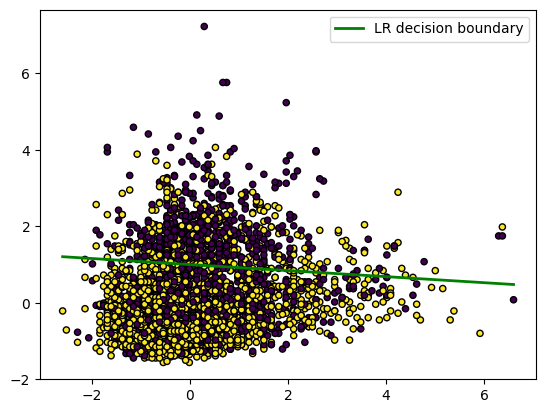

              precision    recall  f1-score   support

     bad[-1]       0.59      0.77      0.67       398
     good[1]       0.83      0.68      0.75       666

    accuracy                           0.71      1064
   macro avg       0.71      0.73      0.71      1064
weighted avg       0.74      0.71      0.72      1064



In [89]:
lr = LogisticRegression(**maximized_tuned_lr_parms)
# lr.fit(transformed_X_train_standard, y_train)
# predictions = lr.predict(transformed_X_test_standard)
lr.fit(X_train_standard, y_train, X_validation=X_test_standard, y_validation=y_test)
predictions = lr.predict(X_test_standard)
#lr.fit(X_train, y_train)
#predictions = lr.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Acc.:{accuracy}')

#print(inspect.signature(lr.visualize_svm))

lr.visualize_lr(np.vstack((X_train_standard, X_test_standard)), np.concatenate((y_train, y_test)))
#print(lr.weights)
#print(lr.bias)
print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

#Kernelized SVM
Non-linear kernels are generally used when we notice that that datapoints of different classes are not linearly serparable, such that there exists an extreme overlapping between classes' data points w.r.t. the original dimensions. Interleaved patterns between classes (non-linear separability) makes it difficult for linear models to find the appropriate decision boundry.
The kernel trick introduces the mapping from the original feature space ϕ of datapoint x to a higher dimensional space exploiting a kernel function `K(x_i,x_j)=ϕ(x_i)⋅ϕ(x_j)`, aiming to find an appropriate decision boundary in the higher dimensional space.
The kernel function to choose depends the prior knowlege of data distribution; in case of no prior knowlege, the gaussian kernel is the most common kernel.

### In case of KSVM
* Training:  
  * Calculate the kernel matrix on the training set through K(X, X) using a predefined kernel function.
  * Resolve the QP problem to determine alpha vector such that 0 <= alpha_i <= regularization term w.r.t. the kernel matrix.
  * Determine labeled support vectors SV w.r.t. the resolved alphas. To avoid SV with α = 0, a common lower threshold should be applied (ex. 0.00001). The maximized margin SV shouldn't exceed the regularization term.
  * Calculate the bias term as `bias = y_k -∑i∈SV * α_i * y_i * K(x_i, x_k)` for such a support vector (x_k,y_k) w.r.t.  any support vectors x_i.

* Prediction:  
To classify a new data point x_test, the decision function is calculated through:
`f(x_test) =∑i∈SV * α_i * y_i * K(x_i, x_test) + bias` where SV refers to the support vectors determined in the training phase, α_i is the alpha multiplier associated to a support vector data point x_i.
The kernel function f(x_test) is used to measure similarity score between the test point and each support vector.
Then we use the sign function (as used in the standard svm) to predict -1 or 1.

In [83]:
#importlib.reload(SVM_Module) # in case of manual updates on colab
#importlib.reload(Kernel_Module) # in case of manual updates on colab

print('-----------------------------------gaussian kernel on SVM-----------------------------------')
# ksvm = SVM(kernel=Kernel(X_train_standard))
# # ksvm.fit(transformed_X_train_standard, y_train)
# # predictions = ksvm.predict(transformed_X_test_standard)
# ksvm.fit(X_train_standard, y_train)
# predictions = ksvm.predict(X_test_standard)
# #ksvm.fit(X_train, y_train)
# #predictions = ksvm.predict(X_test)

# accuracy = np.sum(predictions == y_test) / len(y_test)
# print(f'Acc.:{accuracy}')

# print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

-----------------------------------gaussian kernel on SVM-----------------------------------


In [84]:
#importlib.reload(SVM_Module) # in case of manual updates on colab
#importlib.reload(Kernel_Module) # in case of manual updates on colab

print('-----------------------------------polynomial kernel on SVM-----------------------------------')
# ksvm = SVM(kernel=Kernel(X_train_standard, kernal_func=Kernel.polynomial_kernel))
# # ksvm.fit(transformed_X_train_standard, y_train)
# # predictions = ksvm.predict(transformed_X_test_standard)
# ksvm.fit(X_train_standard, y_train)
# predictions = ksvm.predict(X_test_standard)
# #ksvm.fit(X_train, y_train)
# #predictions = ksvm.predict(X_test)

# accuracy = np.sum(predictions == y_test) / len(y_test)
# print(f'Acc.:{accuracy}')

# print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

-----------------------------------polynomial kernel on SVM-----------------------------------


#Notes on the difference between applying gaussian kernel and polynomial kernel on SVM
As noticed the gaussian-based KSVM has 0 permformance for the minor class `bad[-1]` which means that gaussian-based KSVM has a generalization problem in case of imbalanced dataset; in essence, the gaussian-based KSVM suffers from high-class influence based on:
* Each support vector in the gaussian-based KSVM effectively creates a "bubble" of influence around itself. The decision boundary is formed by the combination of these bubbles.

* In an imbalanced dataset, if the minority class points are sparse, a gaussian kernel will struggle to connect these isolated points to form a cohesive decision boundary for the entire minority class; therfore, the dense majority class might dominate the decision space.

* Gamma Sensitivity: If gamma is too high, the bubbles are very small, and minority class points become even more isolated. If gamma is too low, the kernel becomes more linear. So it needs to be carefully tuned.

Meanwhile the polynomial-based KSVM has more global influence:
* Polynomial kernel can a generate broader by sweeping decision surfaces that can span larger areas of the feature space.

* The nature of connecting sparse points allows it to draw a more general boundary that can encompass the more sparsely distributed minority class points, even if they are not tightly clustered. It's less sensitive to the immediate density around individual points.

#Consequences on the prediction and performance in case of kernelized SVM

* Prediction:  
  * The prediction phase becomes more complex and time consuming since it needs to calculate the test kernel matrix K(X_test, sv) based on the predefined support vectors.
  It also uses the alpha vector and the bias term pre-calculated in the training phase.
  * Since the non-linear boundaries can be very complex. This increases the model's capacity to fit more the training data.
  This also increases the risk of overfitting if the kernel-specific hyperparameters in additional to normal svm hyperparameters are not tuned correctly.

* Performance
  * Increased Time Complexity:
    - The Computation of Kernel Matrix: The most significant bottleneck during training is the computation of the kernel matrix to be defined in the training phase, which is an N×N matrix where N is the number of training samples. Each entry K_i_j requires a kernel evaluation. This leads to an O(N^2) complexity for constructing the matrix. For large datasets, N2 grows very quickly, making kernelized SVM much slower than linear SVMs.

    - Quadratic Programming (QP) Solver: Solving the underlying QP problem to find the optimal alpha multipliers (α) also typically scales between O(N^2) and O(N^3) This again depends heavily on N.

    - Additional Hyperparameter Tuning: Kernelized SVM introduce more hyperparameters to be tuned (ex. gamma, degree, ...) that need extensive tuning w.r.t. the chosen kernel function. Each combination requires retraining the entire model, multiplying the training time significantly for each time we need to tune a single combination of hyperparameters.
  * Increased Space Complexity:
    - Storing the N×N kernel matrix during training requires O(N2) memory, which can quickly become a challenge for large datasets.

    - The trained model needs to store all support vectors SV(and their associated α and labels) for prediction, leading to O(Nsv * D) memory consumption for the model itself, for the dimension space D.

#Comparison between standard SVM and kernelized SVM
  * The created non-linear decision boundary in the original input space, allows KSVM to model complex relationships in data that would be impossible with a simple linear SVM.
  
  * Unlike a linear SVM, where the weight vector directly tells us the importance and direction of each feature, a KSVM's decision boundary is defined by a weighted sum of kernel evaluations with support vectors. Which makes it much harder to interpret the direct relationship between input features and the decision boundary.
  * Standard SVM may underfit if the data truly requires a non-linear boundary, since it won't handle the underlying relationship between features and labels. Meanwhile KSVM may overfit if the hyperparameters aren't well-tuned given the high dimensionality mapping.
  * The phase of hyperparameter tuning in KSVM is relatively high w.r.t. the standard SVM. It needs extensive tuning w.r.t. the chosen kernel function retraining the entire model over the high-dimensional mapped datapoints. Which introduces a real challange for large-sized datasets.

#Performance plot

In [85]:
'''
model_evaluation should contain loss, val_loss, accuracy, val_accuracy
'''
def performance_plot(model_evaluation:dict):
    plt.figure(figsize=(16, 6))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_evaluation['loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model_evaluation['accuracy'])
    plt.plot(model_evaluation['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.legend(['training', 'validation'])

    plt.show()

#SVM Performance Evaluation

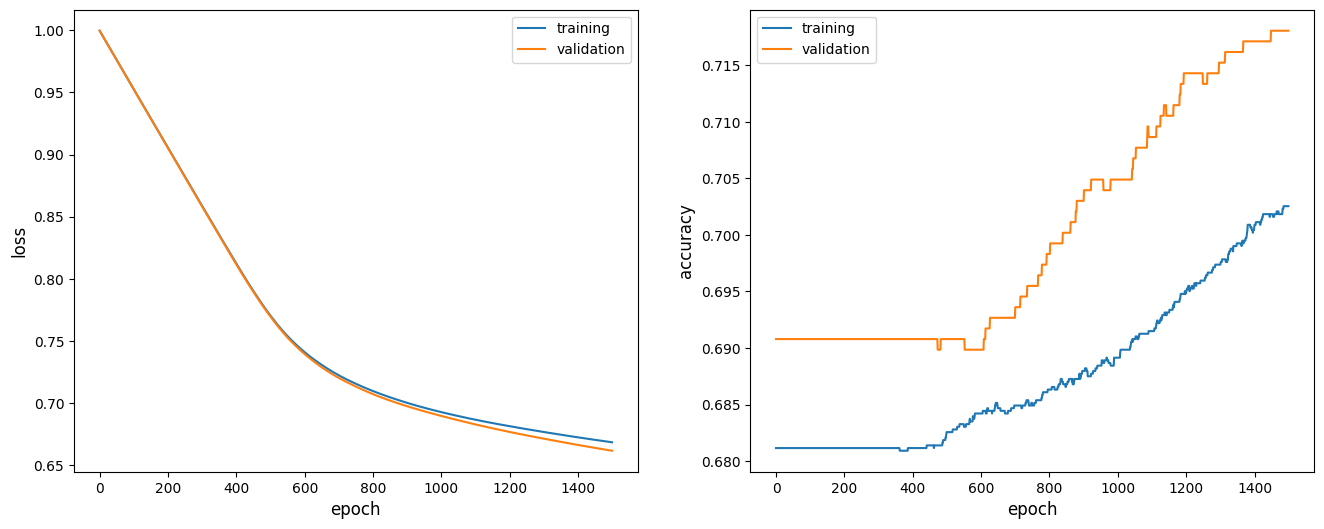

In [86]:
performance_plot(svm.get_model_metrics_evaluation())

# LR Performance Evaluation

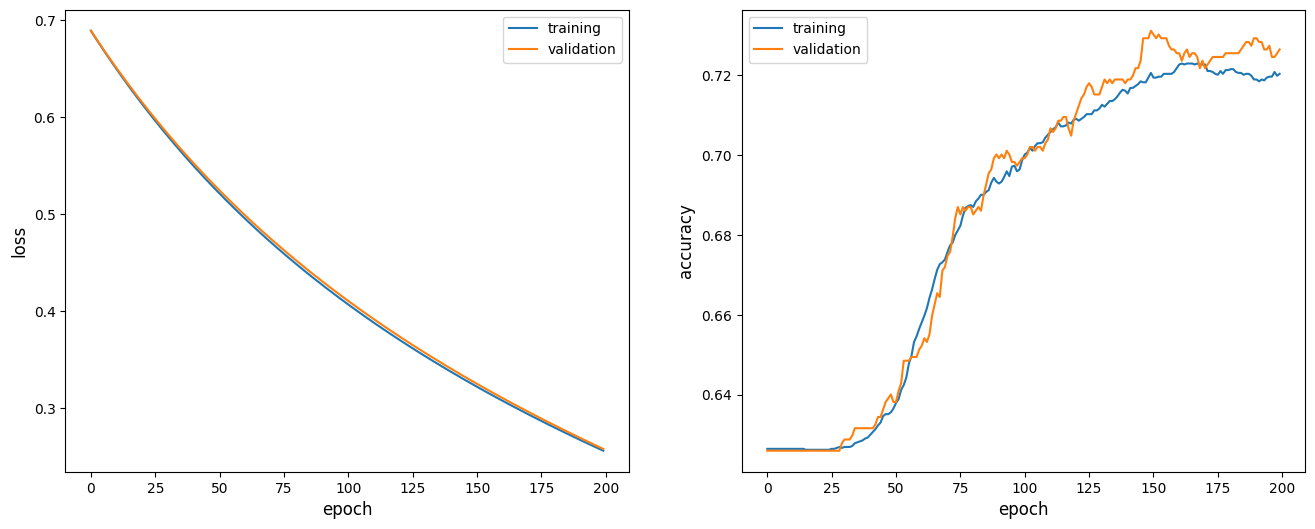

In [87]:
performance_plot(lr.get_model_metrics_evaluation())